# Inference example for trained 2D U-Net model.
Takes a trained model and performs inference on a few validation examples.

In [1]:
import sys
import platform
import os

print("Python version: {}".format(sys.version))
print("{}".format(platform.platform()))

Python version: 3.10.9 (v3.10.9:1dd9be6584, Dec  6 2022, 14:37:36) [Clang 13.0.0 (clang-1300.0.29.30)]
macOS-13.1-arm64-arm-64bit


In [2]:
saved_model_dir = "output/2d_unet_decathlon"

In [3]:
# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)
    
model_filename = os.path.join(saved_model_dir)

In [4]:
import numpy as np

def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorensen Dice coefficient
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

def calc_soft_dice(target, prediction, smooth=0.0001):
    """
    Sorensen (Soft) Dice coefficient - Don't round predictions
    """
    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

## Inference Phase!

#### Step 1 : Load data

In [5]:
data_path = "Task01_BrainTumour/"

crop_dim=128  # Original resolution (240)
batch_size = 128
seed=9999
train_test_split=0.80

In [6]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_test = DatasetGenerator(testFiles, 
                           batch_size=batch_size, 
                           crop_dim=[crop_dim, crop_dim], 
                           augment=False, 
                           seed=seed)


******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 387
Number of validation files = 48
Number of testing files    = 49


#### Step 2 : Load the model

In [7]:
from model import unet

from tensorflow import keras as K
model = K.models.load_model(saved_model_dir, compile=False, custom_objects=unet().custom_objects)

Data format = channels_last


#### Step 3: Perform prediction on some images. 
The prediction results will be saved in the output directory for images, which is defined by the `png_directory` variable.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import time

def plot_results(ds):
    
    plt.figure(figsize=(10,10))

    img, msk = next(ds.ds)

    idx = np.argmax(np.sum(np.sum(msk[:,:,:,0], axis=1), axis=1)) # find the slice with the largest tumor

    plt.subplot(1, 3, 1)
    plt.imshow(img[idx, :, :, 0], cmap="bone", origin="lower")
    plt.title("MRI {}".format(idx), fontsize=20, fontname='Monaco')

    plt.subplot(1, 3, 2)
    plt.imshow(msk[idx, :, :], cmap="bone", origin="lower")
    plt.title("Ground truth", fontsize=20, fontname='Monaco')

    plt.subplot(1, 3, 3)

    print("Index {}: ".format(idx), end="")
    
    # Predict using the TensorFlow model
    start_time = time.time()
    prediction = model.predict(img[[idx]])
    print("Elapsed time = {:.4f} msecs, ".format(1000.0*(time.time()-start_time)), end="")
    
    plt.imshow(prediction[0,:,:,0], cmap="bone", origin="lower")
    dice_coef = calc_dice(msk[idx], prediction)
    print("Dice coefficient = {:.4f}, ".format(dice_coef), end="")
    plt.title("Prediction\nDice = {:.4f}".format(dice_coef), fontsize=20, fontname='Monaco')


1/1 [==============================] - 0s 131ms/step
Elapsed time = 159.7772 msecs, Dice coefficient = 0.8724, 

2022-12-30 15:59:04.153909: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


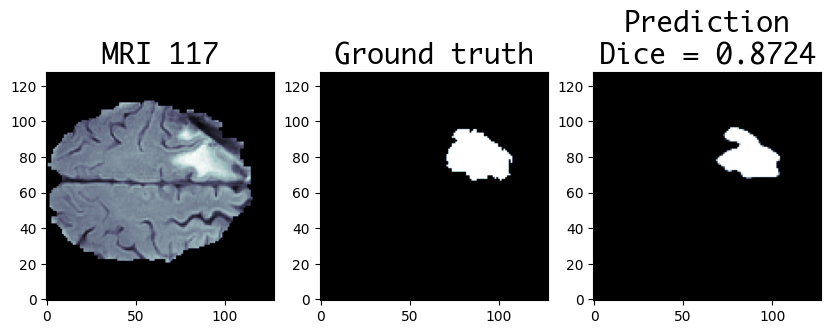

In [9]:
plot_results(ds_test)

1/1 [==============================] - 0s 18ms/step
Elapsed time = 38.6770 msecs, Dice coefficient = 0.9630, 

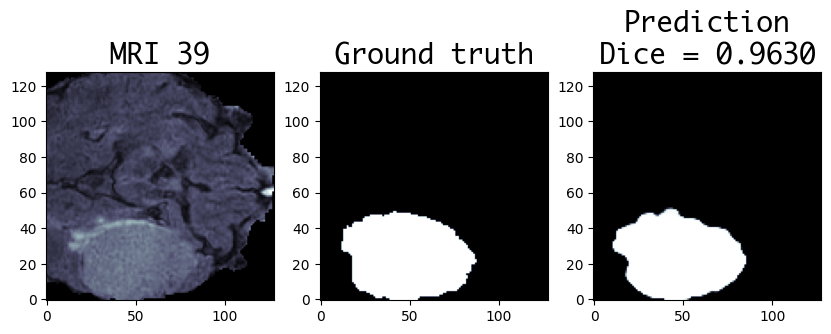

In [10]:
plot_results(ds_test)

1/1 [==============================] - 0s 20ms/step
Elapsed time = 40.7970 msecs, Dice coefficient = 0.1168, 

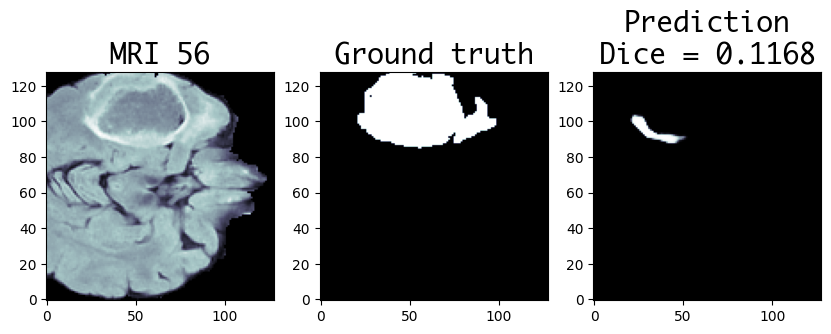

In [11]:
plot_results(ds_test)

1/1 [==============================] - 0s 19ms/step
Elapsed time = 38.7409 msecs, Dice coefficient = 0.8373, 

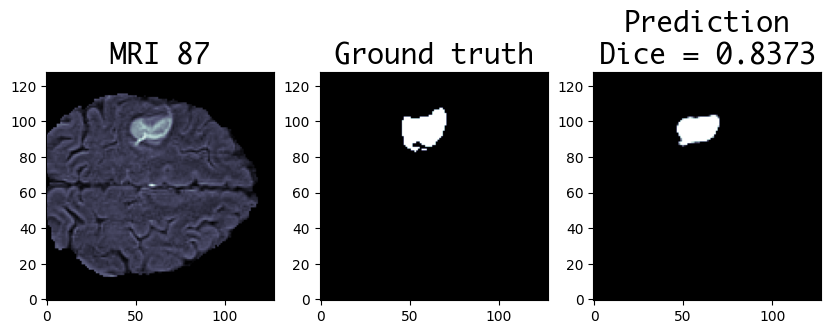

In [12]:
plot_results(ds_test)

1/1 [==============================] - 0s 19ms/step
Elapsed time = 38.2309 msecs, Dice coefficient = 0.7959, 

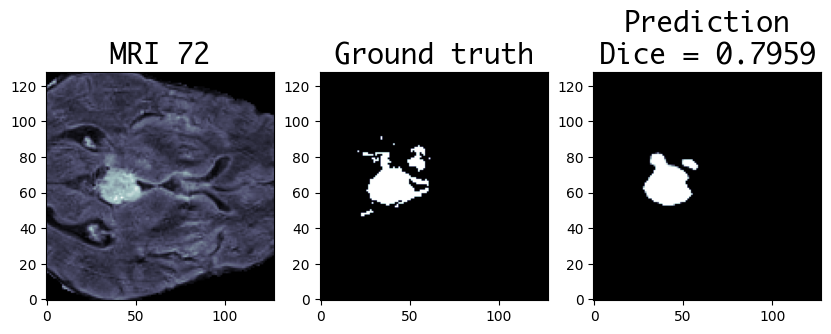

In [13]:
plot_results(ds_test)

1/1 [==============================] - 0s 18ms/step
Elapsed time = 38.3999 msecs, Dice coefficient = 0.9010, 

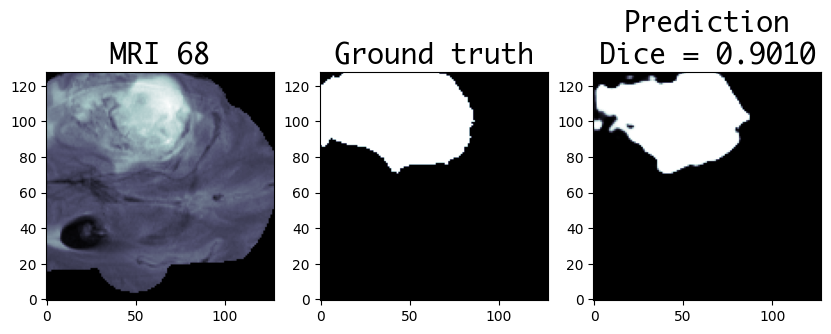

In [23]:
plot_results(ds_test)

1/1 [==============================] - 0s 17ms/step
Elapsed time = 36.6869 msecs, Dice coefficient = 0.7449, 

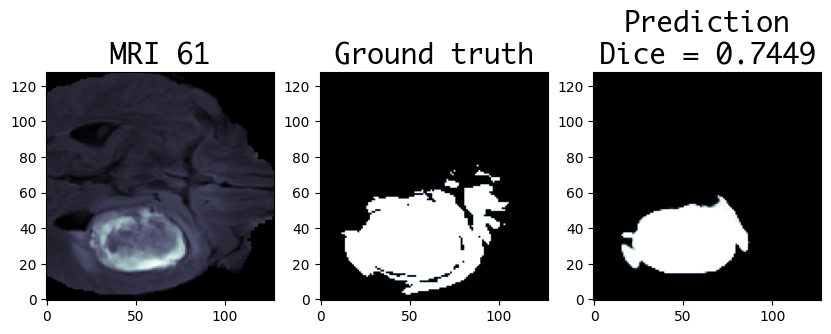

In [15]:
plot_results(ds_test)